In [1]:
import os, math, json, textwrap
from pathlib import Path
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
# Matplotlib rules: matplotlib only, one chart per figure, no custom colors
plt.rcParams.update({'figure.autolayout': True})

DATA_PATH = "/content/apple_music_dataset.csv"   # <-- change if needed
OUTPUT_DIR = Path("/content")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
def snake_case(name: str) -> str:
    s = name.strip().replace("/", " ").replace("\\", " ").replace("-", " ").replace(".", " ").replace("(", " ").replace(")", " ")
    out = []
    prev_lower = False
    for ch in s:
        if ch.isupper() and prev_lower:
            out.append("_")
        out.append(ch.lower())
        prev_lower = ch.isalpha() and ch.islower()
    s = "".join(out)
    s = "_".join([seg for seg in s.replace("  ", " ").split() if seg])
    s = s.replace("__", "_")
    return s

In [8]:
def safe_parse_datetime(series: pd.Series):
    try:
        return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
    except Exception:
        return pd.to_datetime(series, errors="coerce")

In [9]:
def try_infer_year(df: pd.DataFrame):
    date_like_cols = [c for c in df.columns if ("date" in c) or ("release" in c) or ("year" in c)]
    year_col = None
    for c in date_like_cols:
        if "year" in c and pd.api.types.is_integer_dtype(df[c]):
            year_col = c
            break
    if year_col is None:
        for c in date_like_cols:
            parsed = safe_parse_datetime(df[c])
            if parsed.notna().sum() > max(1, int(0.2 * len(df))):
                df["release_year"] = parsed.dt.year
                return df
    else:
        df["release_year"] = pd.to_numeric(df[year_col], errors="coerce")
        return df
    return df


In [10]:
def add_duration_minutes(df: pd.DataFrame):
    candidates = ["duration_ms", "track_time_ms", "time_ms", "length_ms", "duration", "length", "track_duration"]
    for c in candidates:
        if c in df.columns:
            if "ms" in c or (pd.api.types.is_numeric_dtype(df[c]) and df[c].median() and df[c].median() > 1000):
                df["duration_min"] = pd.to_numeric(df[c], errors="coerce") / 60000.0
                return df
            vals = pd.to_numeric(df[c], errors="coerce")
            if vals.notna().sum() and 0 < float(vals.median()) < 30:
                df["duration_min"] = vals
                return df
    # Try parsing "mm:ss" or "hh:mm:ss"
    text_cols = [c for c in df.columns if any(k in c for k in ["time", "duration", "length"])]
    for c in text_cols:
        if c in df.columns and df[c].dtype == object:
            def parse_mmss(x):
                try:
                    if isinstance(x, str) and ":" in x:
                        parts = x.split(":")
                        if len(parts) == 2:
                            m, s = int(parts[0]), float(parts[1])
                            return (m * 60 + s) / 60.0
                        elif len(parts) == 3:
                            h, m, s = int(parts[0]), int(parts[1]), float(parts[2])
                            return (h * 3600 + m * 60 + s) / 60.0
                except Exception:
                    return np.nan
                return np.nan
            parsed = pd.to_numeric(df[c], errors="coerce")
            if parsed.isna().all():
                df["duration_min"] = df[c].apply(parse_mmss)
                if df["duration_min"].notna().sum() > max(1, int(0.2 * len(df))):
                    return df
    return df

In [11]:
def iqr_bounds(series: pd.Series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr


In [12]:
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
print("Raw columns:", list(df.columns))
display(df.head(5))


Raw shape: (10000, 24)
Raw columns: ['artistId', 'artistName', 'collectionCensoredName', 'collectionId', 'collectionName', 'collectionPrice', 'contentAdvisoryRating', 'country', 'currency', 'discCount', 'discNumber', 'isStreamable', 'kind', 'previewUrl', 'primaryGenreName', 'releaseDate', 'trackCensoredName', 'trackCount', 'trackExplicitness', 'trackId', 'trackName', 'trackNumber', 'trackPrice', 'trackTimeMillis']


,artistId,artistName,collectionCensoredName,collectionId,collectionName,collectionPrice,contentAdvisoryRating,country,currency,discCount,...,primaryGenreName,releaseDate,trackCensoredName,trackCount,trackExplicitness,trackId,trackName,trackNumber,trackPrice,trackTimeMillis
0,46087,Erick Sermon,Music,298321651,Music,9.99,Explicit,USA,USD,1,...,Hip-Hop/Rap,2001-08-27T12:00:00Z,Music (feat. Marvin Gaye),16,explicit,298321904,Music,4,1.29,223133
1,20044,Madonna,Music,80815197,Music,9.99,NaN,USA,USD,1,...,Pop,2000-08-21T07:00:00Z,Music,10,notExplicit,80815173,Music,1,1.29,225973
2,486597,Journey,Greatest Hits (2024 Remaster),169003304,Greatest Hits (2024 Remaster),10.99,NaN,USA,USD,1,...,Rock,1981-06-03T07:00:00Z,Don't Stop Believin' (2024 Remaster),16,notExplicit,169003415,Don't Stop Believin' (2024 Remaster),2,1.29,250835
3,156987,Jason Mraz,We Sing. We Dance. We Steal Things,277635758,We Sing. We Dance. We Steal Things,11.99,NaN,USA,USD,1,...,Pop,2008-02-12T08:00:00Z,I'm Yours,12,notExplicit,277635828,I'm Yours,2,1.29,242947
4,46087,Erick Sermon,Music,298429528,Music,9.99,Clean,USA,USD,1,...,Hip-Hop/Rap,2001-05-29T07:00:00Z,Music (feat. Marvin Gaye),16,cleaned,298429596,Music,4,1.29,223133


In [13]:
df.columns = [snake_case(c) for c in df.columns]
print("Cleaned columns:", list(df.columns))
display(df.head(5))

Cleaned columns: ['artist_id', 'artist_name', 'collection_censored_name', 'collection_id', 'collection_name', 'collection_price', 'content_advisory_rating', 'country', 'currency', 'disc_count', 'disc_number', 'is_streamable', 'kind', 'preview_url', 'primary_genre_name', 'release_date', 'track_censored_name', 'track_count', 'track_explicitness', 'track_id', 'track_name', 'track_number', 'track_price', 'track_time_millis']


,artist_id,artist_name,collection_censored_name,collection_id,collection_name,collection_price,content_advisory_rating,country,currency,disc_count,...,primary_genre_name,release_date,track_censored_name,track_count,track_explicitness,track_id,track_name,track_number,track_price,track_time_millis
0,46087,Erick Sermon,Music,298321651,Music,9.99,Explicit,USA,USD,1,...,Hip-Hop/Rap,2001-08-27T12:00:00Z,Music (feat. Marvin Gaye),16,explicit,298321904,Music,4,1.29,223133
1,20044,Madonna,Music,80815197,Music,9.99,NaN,USA,USD,1,...,Pop,2000-08-21T07:00:00Z,Music,10,notExplicit,80815173,Music,1,1.29,225973
2,486597,Journey,Greatest Hits (2024 Remaster),169003304,Greatest Hits (2024 Remaster),10.99,NaN,USA,USD,1,...,Rock,1981-06-03T07:00:00Z,Don't Stop Believin' (2024 Remaster),16,notExplicit,169003415,Don't Stop Believin' (2024 Remaster),2,1.29,250835
3,156987,Jason Mraz,We Sing. We Dance. We Steal Things,277635758,We Sing. We Dance. We Steal Things,11.99,NaN,USA,USD,1,...,Pop,2008-02-12T08:00:00Z,I'm Yours,12,notExplicit,277635828,I'm Yours,2,1.29,242947
4,46087,Erick Sermon,Music,298429528,Music,9.99,Clean,USA,USD,1,...,Hip-Hop/Rap,2001-05-29T07:00:00Z,Music (feat. Marvin Gaye),16,cleaned,298429596,Music,4,1.29,223133


In [14]:
print(df.info())
missing = df.isna().sum().sort_values(ascending=False)
missing_ratio = (df.isna().sum() / len(df)).sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   artist_id                 10000 non-null  int64  
 1   artist_name               10000 non-null  object 
 2   collection_censored_name  10000 non-null  object 
 3   collection_id             10000 non-null  int64  
 4   collection_name           10000 non-null  object 
 5   collection_price          9919 non-null   float64
 6   content_advisory_rating   1512 non-null   object 
 7   country                   10000 non-null  object 
 8   currency                  10000 non-null  object 
 9   disc_count                10000 non-null  int64  
 10  disc_number               10000 non-null  int64  
 11  is_streamable             9999 non-null   object 
 12  kind                      10000 non-null  object 
 13  preview_url               10000 non-null  object 
 14  primary

In [15]:
display(missing.head(30).to_frame("missing_count"))
display(missing_ratio.head(30).to_frame("missing_ratio"))


,missing_count
content_advisory_rating,8488
collection_price,81
track_price,24
is_streamable,1
collection_id,0
collection_censored_name,0
artist_id,0
artist_name,0
country,0
collection_name,0


,missing_ratio
content_advisory_rating,0.8488
collection_price,0.0081
track_price,0.0024
is_streamable,0.0001
collection_id,0.0000
collection_censored_name,0.0000
artist_id,0.0000
artist_name,0.0000
country,0.0000
collection_name,0.0000


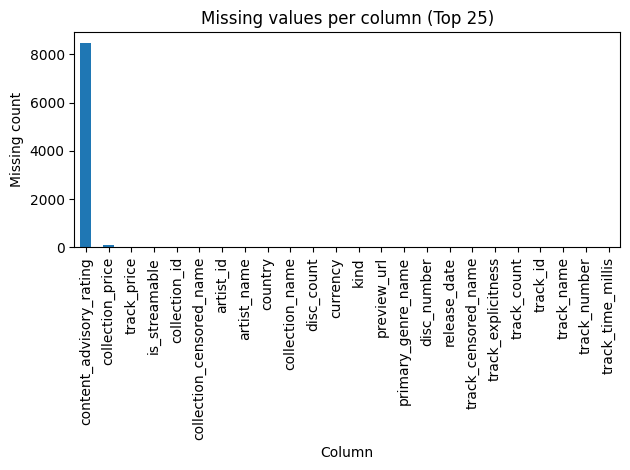

In [16]:
plt.figure()
missing.head(25).plot(kind="bar")
plt.title("Missing values per column (Top 25)")
plt.xlabel("Column")
plt.ylabel("Missing count")
plt.tight_layout()
plt.show()

In [17]:
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after dedup:", df.shape)


Duplicate rows: 1259
Shape after dedup: (8741, 24)


In [18]:
# ================== CELL 8: Feature Engineering ==================
df = try_infer_year(df)
df = add_duration_minutes(df)

track_col = next((c for c in ["track_name","name","track","song","title"] if c in df.columns), None)
artist_col = next((c for c in ["artist_name","artist"] if c in df.columns), None)
album_col  = next((c for c in ["album_name","album"] if c in df.columns), None)
genre_col  = next((c for c in ["primary_genre_name","genre","genres"] if c in df.columns), None)
pop_col    = next((c for c in ["popularity","track_popularity","pop"] if c in df.columns), None)
explicit_col = next((c for c in ["explicit","is_explicit","explicitness"] if c in df.columns), None)

cols_added = [c for c in ["release_year","duration_min"] if c in df.columns]
print("Engineered columns added:", cols_added)
display(df.head(5))

Engineered columns added: ['release_year']


/tmp/ipython-input-2962343604.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)


,artist_id,artist_name,collection_censored_name,collection_id,collection_name,collection_price,content_advisory_rating,country,currency,disc_count,...,release_date,track_censored_name,track_count,track_explicitness,track_id,track_name,track_number,track_price,track_time_millis,release_year
0,46087,Erick Sermon,Music,298321651,Music,9.99,Explicit,USA,USD,1,...,2001-08-27T12:00:00Z,Music (feat. Marvin Gaye),16,explicit,298321904,Music,4,1.29,223133,2001
1,20044,Madonna,Music,80815197,Music,9.99,NaN,USA,USD,1,...,2000-08-21T07:00:00Z,Music,10,notExplicit,80815173,Music,1,1.29,225973,2000
2,486597,Journey,Greatest Hits (2024 Remaster),169003304,Greatest Hits (2024 Remaster),10.99,NaN,USA,USD,1,...,1981-06-03T07:00:00Z,Don't Stop Believin' (2024 Remaster),16,notExplicit,169003415,Don't Stop Believin' (2024 Remaster),2,1.29,250835,1981
3,156987,Jason Mraz,We Sing. We Dance. We Steal Things,277635758,We Sing. We Dance. We Steal Things,11.99,NaN,USA,USD,1,...,2008-02-12T08:00:00Z,I'm Yours,12,notExplicit,277635828,I'm Yours,2,1.29,242947,2008
4,46087,Erick Sermon,Music,298429528,Music,9.99,Clean,USA,USD,1,...,2001-05-29T07:00:00Z,Music (feat. Marvin Gaye),16,cleaned,298429596,Music,4,1.29,223133,2001


In [19]:
num_df = df.select_dtypes(include=[np.number]).copy()
if num_df.shape[1] > 0:
    display(num_df.describe().T)

outlier_rows = []
for c in num_df.columns:
    s = num_df[c].dropna()
    if s.empty:
        continue
    lb, ub = iqr_bounds(s)
    outlier_rows.append({
        "column": c,
        "lower_bound": lb,
        "upper_bound": ub,
        "below_count": int((num_df[c] < lb).sum()),
        "above_count": int((num_df[c] > ub).sum())
    })
outliers_df = pd.DataFrame(outlier_rows)
display(outliers_df.head(30))

,count,mean,std,min,25%,50%,75%,max
artist_id,8741.0,1.680643e+08,2.702524e+08,11955.0,4.694760e+05,6.766228e+06,2.757276e+08,1.668991e+09
collection_id,8741.0,5.826632e+08,4.356594e+08,160967.0,2.597540e+08,4.186741e+08,9.095616e+08,1.727624e+09
collection_price,8672.0,1.104582e+01,4.272438e+00,-1.0,9.990000e+00,9.990000e+00,1.299000e+01,1.499900e+02
disc_count,8741.0,1.094040e+00,4.609089e-01,1.0,1.000000e+00,1.000000e+00,1.000000e+00,2.800000e+01
disc_number,8741.0,1.040842e+00,2.781969e-01,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01
track_count,8741.0,1.462007e+01,6.873716e+00,1.0,1.200000e+01,1.400000e+01,1.700000e+01,1.000000e+02
track_id,8741.0,5.826335e+08,4.356938e+08,160953.0,2.597543e+08,4.186741e+08,9.095616e+08,1.727624e+09
track_number,8741.0,6.852305e+00,5.781236e+00,1.0,2.000000e+00,5.000000e+00,1.000000e+01,8.800000e+01
track_price,8720.0,1.195210e+00,4.176723e-01,-1.0,1.290000e+00,1.290000e+00,1.290000e+00,1.990000e+00
track_time_millis,8741.0,2.332526e+05,6.518365e+04,8192.0,1.979200e+05,2.255200e+05,2.590640e+05,9.435290e+05


,column,lower_bound,upper_bound,below_count,above_count
0,artist_id,-4.124177e+08,6.886147e+08,0,541
1,collection_id,-7.149573e+08,1.884273e+09,0,0
2,collection_price,5.490000e+00,1.749000e+01,594,220
3,disc_count,1.000000e+00,1.000000e+00,0,709
4,disc_number,1.000000e+00,1.000000e+00,0,312
5,track_count,4.500000e+00,2.450000e+01,484,451
6,track_id,-7.149568e+08,1.884273e+09,0,0
7,track_number,-1.000000e+01,2.200000e+01,0,133
8,track_price,1.290000e+00,1.290000e+00,728,1
9,track_time_millis,1.062040e+05,3.507800e+05,141,366


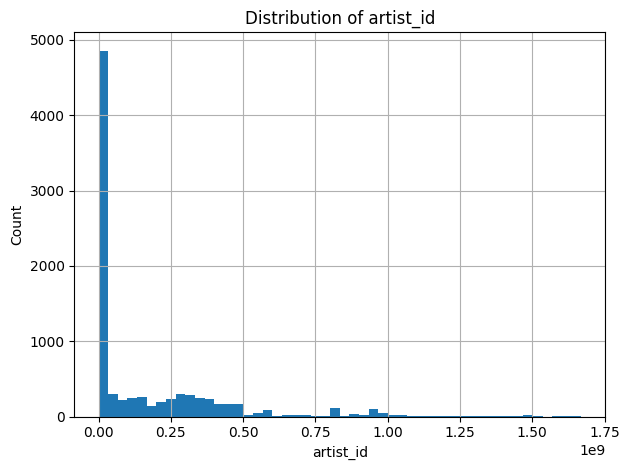

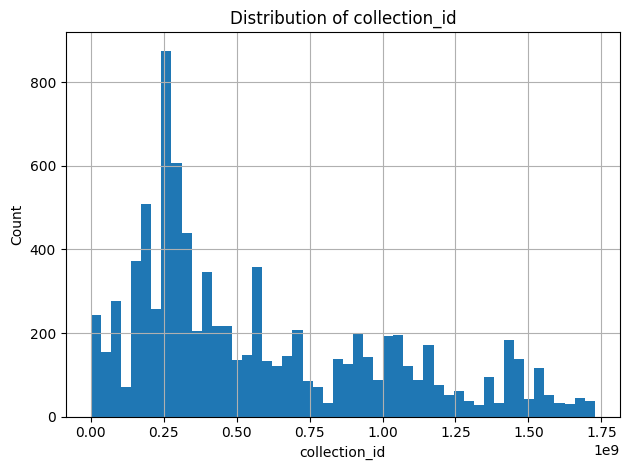

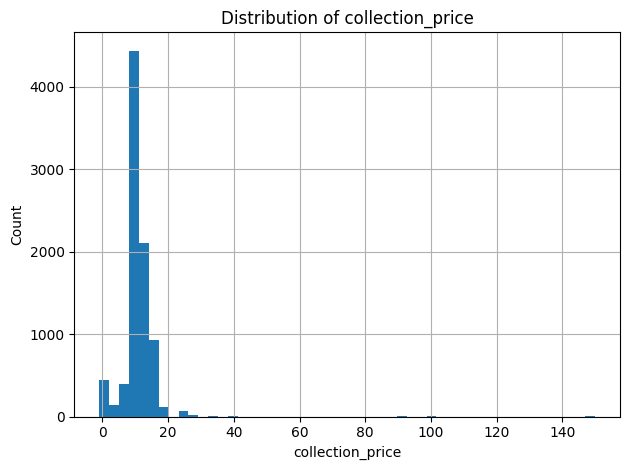

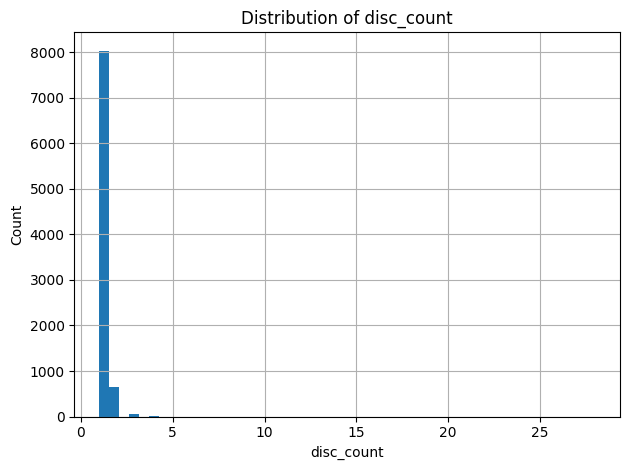

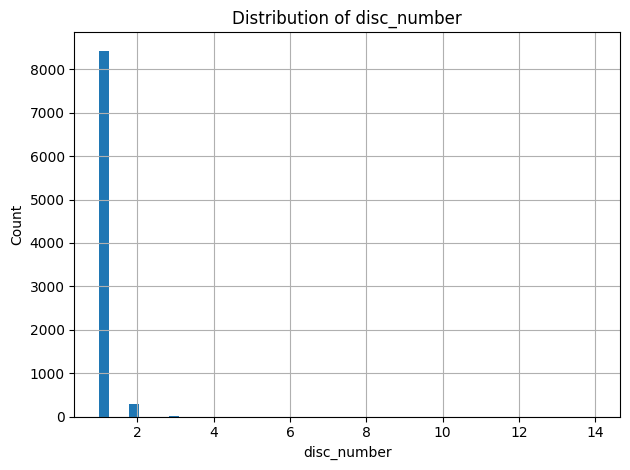

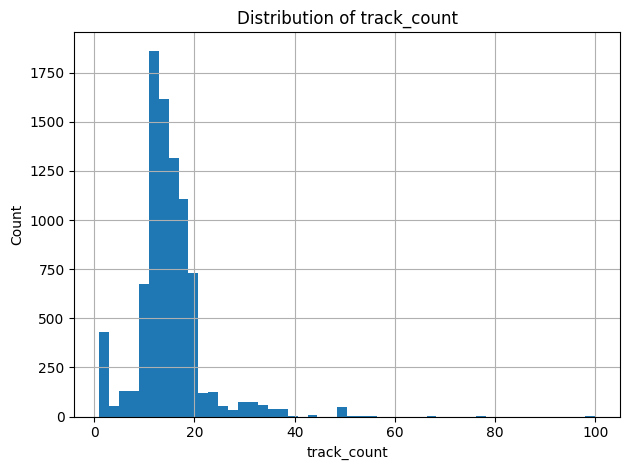

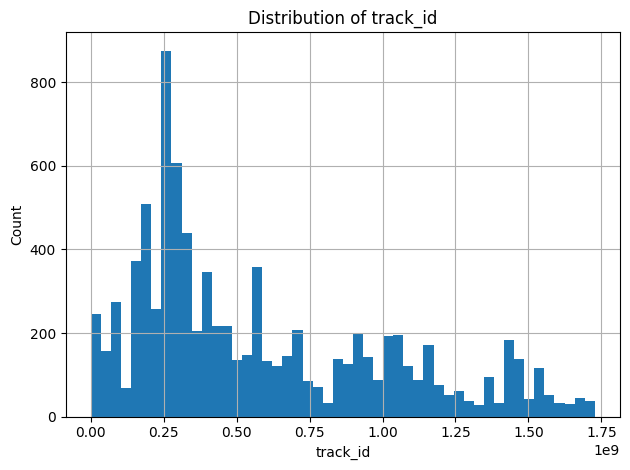

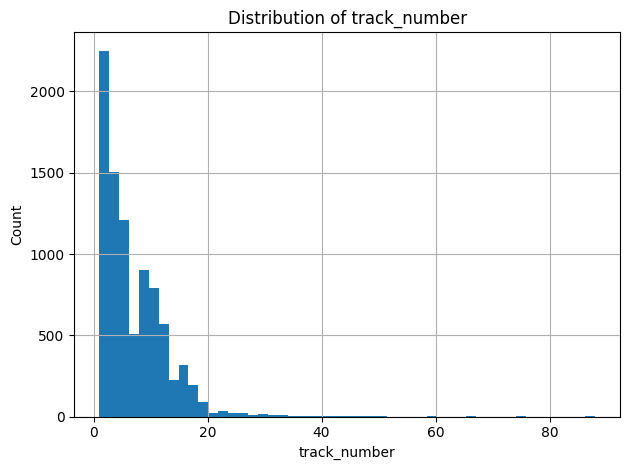

In [22]:
numeric_cols = [c for c in num_df.columns if num_df[c].nunique() > 5]
for c in numeric_cols[:8]:
    plt.figure()
    num_df[c].dropna().hist(bins=50)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()




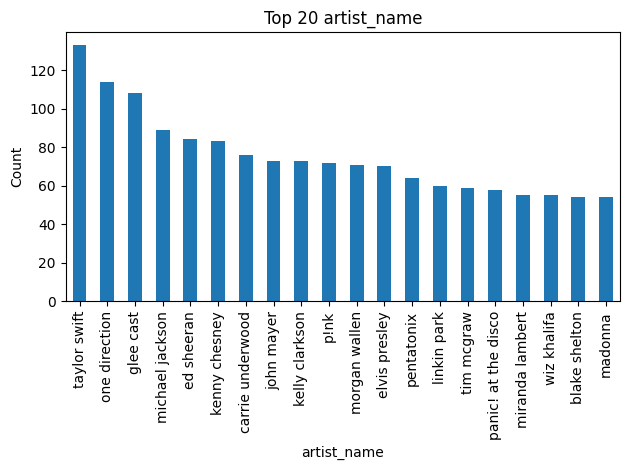

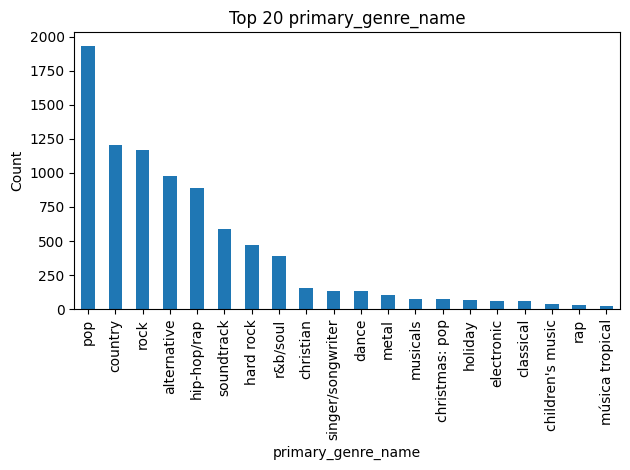

In [24]:
for c in [artist_col, album_col, genre_col]:
    if c is not None and c in df.columns:
        plt.figure()
        df[c].astype(str).str.lower().value_counts().head(20).plot(kind="bar")
        plt.title(f"Top 20 {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()



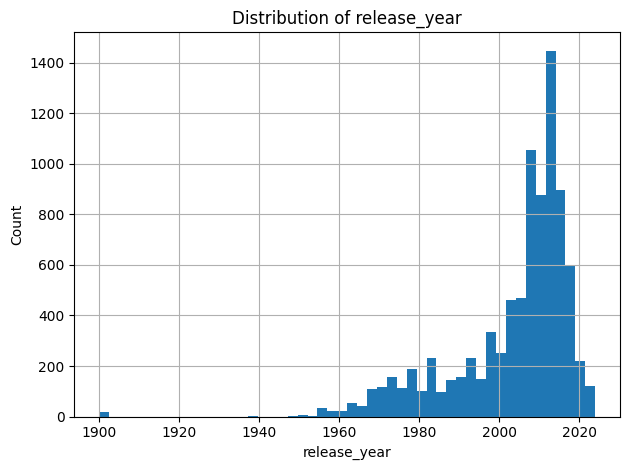

In [30]:
# ================== CELL 11: Year & Duration Visuals ==================
if "release_year" in df.columns:
    plt.figure()
    df["release_year"].dropna().astype(int).hist(bins=50)
    plt.title("Distribution of release_year")
    plt.xlabel("release_year")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
if "duration_min" in df.columns:
    plt.figure()
    df["duration_min"].dropna().hist(bins=50)
    plt.title("Distribution of duration_min")
    plt.xlabel("duration_min")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


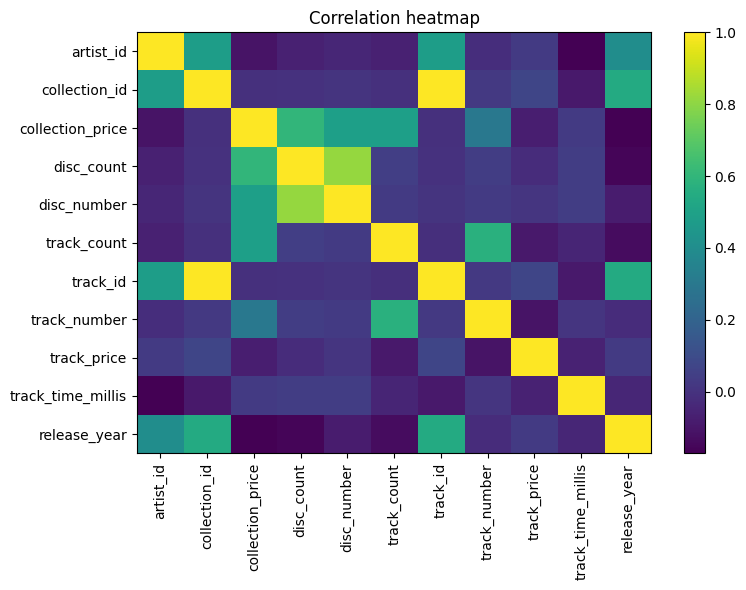

In [32]:
# ================== CELL 12: Bivariate Visuals ==================
if ("duration_min" in df.columns) and (pop_col is not None) and (pop_col in df.columns):
    plt.figure()
    plt.scatter(df["duration_min"], df[pop_col])
    plt.title(f"{pop_col} vs duration_min")
    plt.xlabel("duration_min")
    plt.ylabel(pop_col)
    plt.tight_layout()
    plt.show()

num_df = df.select_dtypes(include=[np.number]).copy()
if num_df.shape[1] > 1:
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    plt.imshow(corr, aspect="auto", interpolation="nearest")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation heatmap")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [33]:
summary_tables = {}

if artist_col and artist_col in df.columns:
    top_artists = df[artist_col].astype(str).str.lower().value_counts().head(25).to_frame("track_count")
    display(top_artists)
    summary_tables["top_artists"] = top_artists

if genre_col and genre_col in df.columns:
    top_genres = df[genre_col].astype(str).str.lower().value_counts().head(25).to_frame("track_count")
    display(top_genres)
    summary_tables["top_genres"] = top_genres

if genre_col and pop_col and genre_col in df.columns and pop_col in df.columns:
    avg_pop_by_genre = (df.groupby(df[genre_col].astype(str).str.lower())[pop_col]
                          .mean().sort_values(ascending=False).head(20)).to_frame("avg_popularity")
    display(avg_pop_by_genre)
    summary_tables["avg_pop_by_genre"] = avg_pop_by_genre

if pop_col and "release_year" in df.columns:
    trend = df.groupby("release_year")[pop_col].mean().dropna().sort_index()
    display(trend.head())
    plt.figure()
    trend.plot()
    plt.title(f"Average {pop_col} by release_year")
    plt.xlabel("release_year")
    plt.ylabel(f"avg_{pop_col}")
    plt.tight_layout()
    plt.show()

if artist_col and pop_col and artist_col in df.columns and pop_col in df.columns:
    artist_stats = (df.groupby(df[artist_col].astype(str).str.lower())
                      .agg(track_count=(artist_col, "size"),
                           avg_popularity=(pop_col, "mean"))
                      .sort_values("track_count", ascending=False))
    display(artist_stats.head(25))
    summary_tables["artist_stats"] = artist_stats

if genre_col and "duration_min" in df.columns:
    dur_by_genre = (df.groupby(df[genre_col].astype(str).str.lower())["duration_min"]
                      .mean().sort_values(ascending=False).head(20)).to_frame("avg_duration_min")
    display(dur_by_genre)
    summary_tables["dur_by_genre"] = dur_by_genre

if explicit_col and explicit_col in df.columns:
    val = df[explicit_col]
    if val.dtype == bool:
        explicit_ratio = float(val.mean())
    else:
        val_norm = val.astype(str).str.lower().isin(["true","1","yes","explicit","t","y"])
        explicit_ratio = float(val_norm.mean())
    print("Explicit tracks ratio:", round(explicit_ratio * 100, 2), "%")

,track_count
artist_name,
taylor swift,133
one direction,114
glee cast,108
michael jackson,89
ed sheeran,84
kenny chesney,83
carrie underwood,76
john mayer,73
kelly clarkson,73


,track_count
primary_genre_name,
pop,1936
country,1208
rock,1169
alternative,979
hip-hop/rap,886
soundtrack,587
hard rock,474
r&b/soul,393
christian,154


In [34]:
# ================== CELL 14: Optional Clustering on Audio Features ==================
audio_features = [c for c in [
    "danceability","energy","valence","tempo","loudness","acousticness","instrumentalness","liveness","speechiness"
] if c in df.columns]

if len(audio_features) >= 3:
    feats = df[audio_features].dropna().copy()
    if len(feats) > 100:
        X = StandardScaler().fit_transform(feats.values)
        kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X)

        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(X)

        plt.figure()
        plt.scatter(X2[:,0], X2[:,1])  # single figure, default colors
        plt.title("Audio feature clusters (PCA 2D, default colors)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.tight_layout()
        plt.show()

        feats = feats.assign(cluster=labels)
        display(feats.head())


In [35]:
CLEAN_CSV = OUTPUT_DIR / "apple_music_eda_clean.csv"
df.to_csv(CLEAN_CSV, index=False)
print("Saved cleaned CSV ->", CLEAN_CSV)

html_path = OUTPUT_DIR / "apple_music_eda_report.html"
parts = []
parts.append("<html><head><meta charset='utf-8'><title>Apple Music EDA Report</title></head><body>")
parts.append("<h1>Apple Music EDA — Summary</h1>")
parts.append(f"<p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>")
parts.append(f"<p>Shape: {df.shape}</p>")
parts.append("<h2>Columns</h2>")
parts.append("<pre>"+ ", ".join(df.columns) + "</pre>")
parts.append("<h2>Missing (top 20)</h2>")
parts.append(missing.head(20).to_frame("missing_count").to_html())
if len(df.select_dtypes(include=[np.number]).columns)>0:
    parts.append("<h2>Numeric describe (first 20 rows)</h2>")
    parts.append(df.select_dtypes(include=[np.number]).describe().T.head(20).to_html())
parts.append("</body></html>")
with open(html_path, "w", encoding="utf-8") as f:
    f.write("\n".join(parts))
print("Saved HTML report ->", html_path)

# Export key summaries if created
try:
    if 'summary_tables' in globals():
        for name, tbl in summary_tables.items():
            outp = OUTPUT_DIR / f"{name}.csv"
            tbl.to_csv(outp)
            print("Saved summary ->", outp)
except Exception as e:
    print("Warning exporting summaries:", e)


Saved cleaned CSV -> /content/apple_music_eda_clean.csv
Saved HTML report -> /content/apple_music_eda_report.html
Saved summary -> /content/top_artists.csv
Saved summary -> /content/top_genres.csv


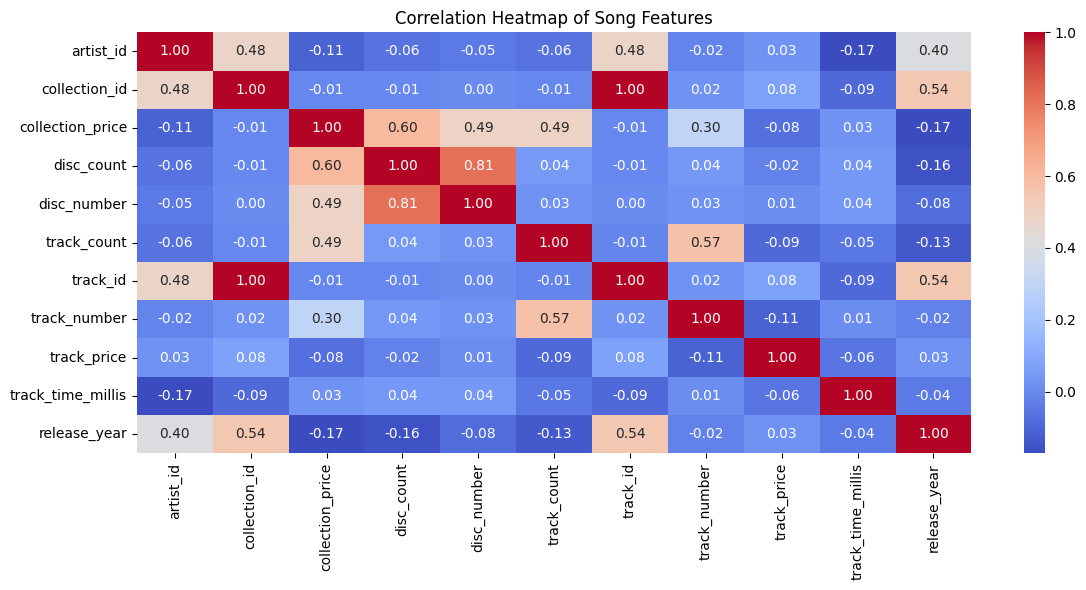

In [37]:
# Import libraries (if not already imported)
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Song Features")
plt.show()

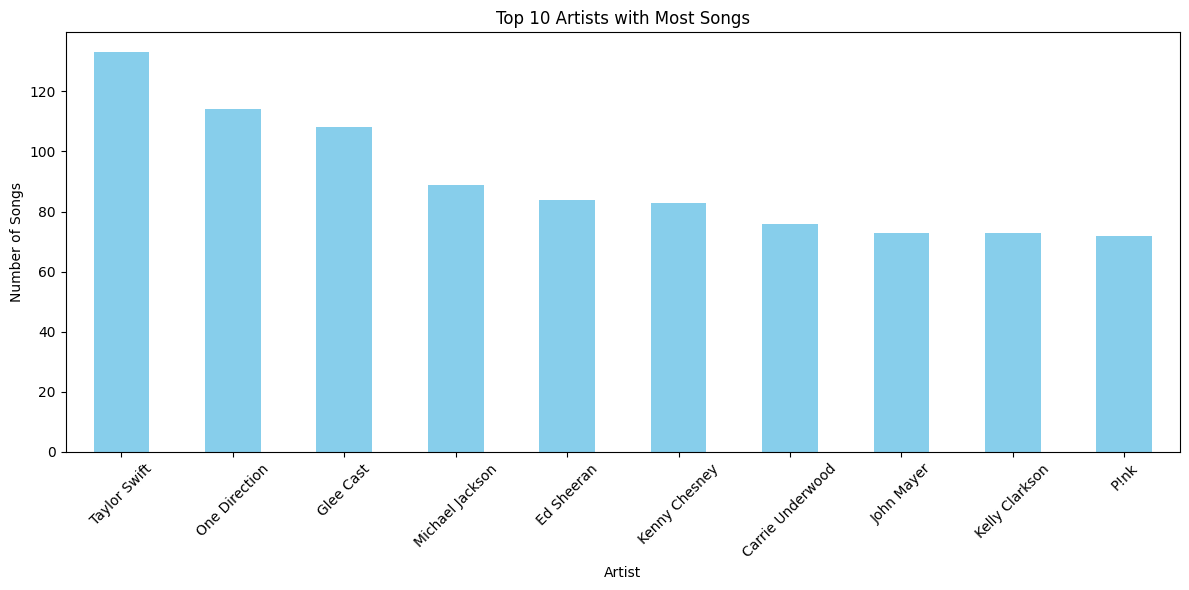

In [42]:
# Top 10 Artists with Most Songs
plt.figure(figsize=(12,6))
df['artist_name'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Artists with Most Songs")
plt.xlabel("Artist")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()


